In [33]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

from ..src.resnet.resnet20 import resnet20
from ..src.evaluate import calculate_accuracy

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

def get_pretrained_model(path):
    model = resnet20()
    model.load_state_dict(torch.load(path, map_location=device)['model_state_dict'])
    model.to(device)
    return model

normalize = transforms.Normalize(mean=[0.491, 0.482, 0.447],
                                  std=[0.247, 0.243, 0.262])
test_dataset = torchvision.datasets.CIFAR10(root='../data', train=False, 
                                            transform=transforms.Compose([
                                                transforms.ToTensor(),
                                                normalize]), download=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=512, 
                                          num_workers=2, pin_memory=True,
                                          shuffle=False, drop_last=False)

Files already downloaded and verified


# ResNet-20

In [66]:
model = get_pretrained_model('../pretrained/model.pth')

print(f'\n\nPretrained model accuracy: {calculate_accuracy(model, test_loader, device)}')

100%|██████████| 20/20 [00:02<00:00,  8.72it/s]



Pretrained model accuracy: 0.9088


In [28]:
total_params = sum(p.numel() for p in model.parameters())
total_conv_params = sum(m.weight.numel() for m in model.modules() if isinstance(m, nn.Conv2d))

print(f'Общее число параметров модели равно {total_params}, из них {total_conv_params} -- параметры сверток.')

Общее число параметров модели равно 269722, из них 267696 -- параметры сверток.


# Pruning

In [68]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import normalize

class KMeans_cosine_distance(KMeans):
    def fit(self, X, y=None, sample_weight=None):
        super().fit(normalize(X, axis=1, norm='l2'))

ResNet-20 состоит из 4 слоев: conv1, layer1, layer2, layer3 --  с количеством фильтров 16, 16, 32, 64 соответсвенно. Запустим прунинг с соответсвующими числами кластеров для сверточных слоев на каждом из слоев модели, чтобы убедиться, что модель не изменится.

In [76]:
from ..src.pruning.cluster_pruning import prune

pruned_model, n_unique_conv_params = prune(model, KMeans_cosine_distance(), 
                                           cluster_nums=[16, 16, 32, 64])
pruned_model.to(device)

print(f'\n\nPruned model accuracy: {calculate_accuracy(pruned_model, test_loader, device)}')
n_unique_conv_params == total_conv_params

100%|██████████| 20/20 [00:02<00:00,  8.80it/s]



Pruned model accuracy: 0.9088


True

## Варьируем число кластеров на layer3

In [117]:
cluster_nums = list(range(4, 65, 4))
compression_ratios = []
accuracies = []

for cluster_num in cluster_nums:
    pruned_model, n_unique_conv_params = prune(model, KMeans_cosine_distance(), 
                                               [16, 16, 32, cluster_num])
    pruned_model.to(device)
    compression_ratio = total_params / (n_unique_conv_params + total_params - total_conv_params)
    accuracy = calculate_accuracy(pruned_model, test_loader, device)
    compression_ratios.append(compression_ratio)
    accuracies.append(accuracy)

100%|██████████| 20/20 [00:02<00:00,  8.95it/s]


In [101]:
import matplotlib.pyplot as plt

def plot(cluster_nums, compression_ratios, accuracies):
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(cluster_nums, compression_ratios, '-o', label='compression_ratio')
    plt.xlabel('cluster_num')
    plt.ylabel('compression_ratio')

    plt.subplot(1, 2, 2)
    plt.plot(cluster_nums, accuracies, '-o', label='accuracy')
    plt.xlabel('cluster_num')
    plt.ylabel('accuracy')

    plt.show()

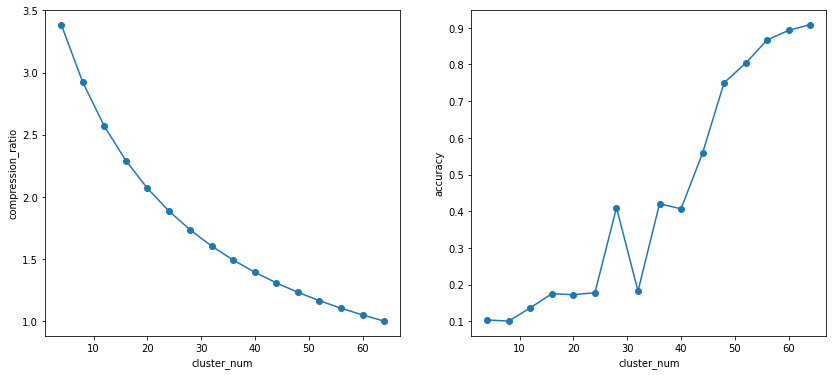

In [118]:
plot(cluster_nums, compression_ratios, accuracies)

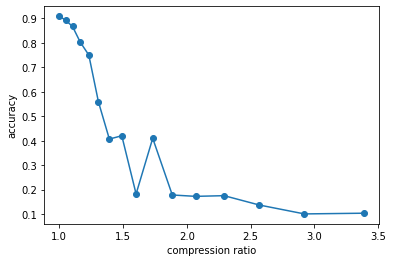

In [119]:
plt.plot(compression_ratios, accuracies, '-o', label='accuracy')
plt.xlabel('compression ratio')
plt.ylabel('accuracy');

## Варьируем число кластеров на layer2

In [120]:
cluster_nums = list(range(2, 33, 2))
compression_ratios = []
accuracies = []

for cluster_num in cluster_nums:
    pruned_model, n_unique_conv_params = prune(model, KMeans_cosine_distance(), 
                                               [16, 16, cluster_num, 64])
    pruned_model.to(device)
    compression_ratio = total_params / (n_unique_conv_params + total_params - total_conv_params)
    accuracy = calculate_accuracy(pruned_model, test_loader, device)
    compression_ratios.append(compression_ratio)
    accuracies.append(accuracy)

100%|██████████| 20/20 [00:02<00:00,  9.03it/s]


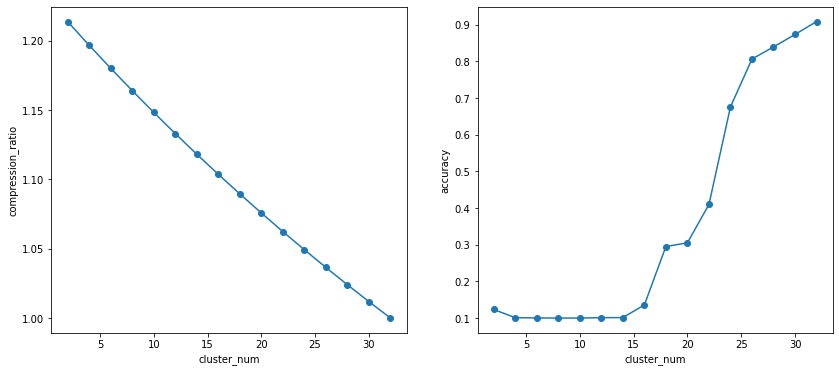

In [121]:
plot(cluster_nums, compression_ratios, accuracies)

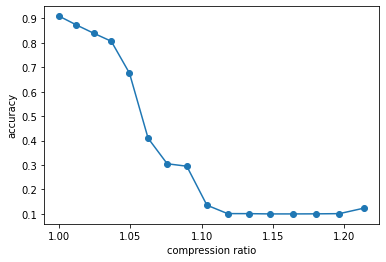

In [122]:
plt.plot(compression_ratios, accuracies, '-o', label='accuracy')
plt.xlabel('compression ratio')
plt.ylabel('accuracy');

## Варьируем число кластеров на layer1

In [123]:
cluster_nums = list(range(2, 17, 2))
compression_ratios = []
accuracies = []

for cluster_num in cluster_nums:
    pruned_model, n_unique_conv_params = prune(model, KMeans_cosine_distance(), 
                                               [16, cluster_num, 32, 64])
    pruned_model.to(device)
    compression_ratio = total_params / (n_unique_conv_params + total_params - total_conv_params)
    accuracy = calculate_accuracy(pruned_model, test_loader, device)
    compression_ratios.append(compression_ratio)
    accuracies.append(accuracy)

100%|██████████| 20/20 [00:02<00:00,  9.04it/s]


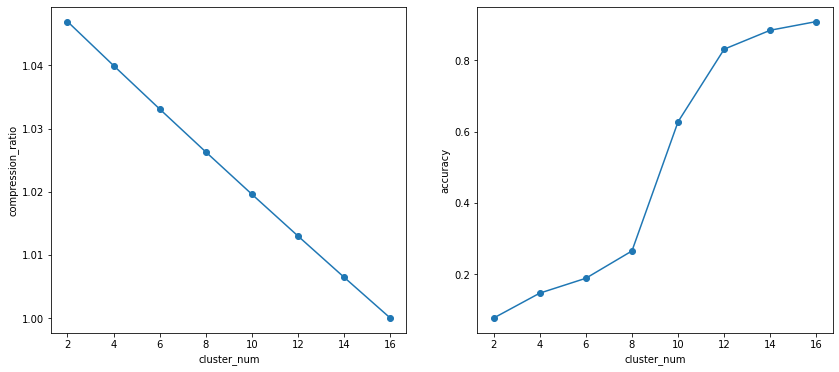

In [124]:
plot(cluster_nums, compression_ratios, accuracies)

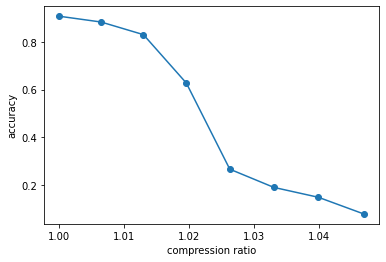

In [125]:
plt.plot(compression_ratios, accuracies, '-o', label='accuracy')
plt.xlabel('compression ratio')
plt.ylabel('accuracy');

## Варьируем число кластеров на conv1

In [126]:
cluster_nums = list(range(2, 17, 2))
compression_ratios = []
accuracies = []

for cluster_num in cluster_nums:
    pruned_model, n_unique_conv_params = prune(model, KMeans_cosine_distance(), 
                                               [cluster_num, 16, 32, 64])
    pruned_model.to(device)
    compression_ratio = total_params / (n_unique_conv_params + total_params - total_conv_params)
    accuracy = calculate_accuracy(pruned_model, test_loader, device)
    compression_ratios.append(compression_ratio)
    accuracies.append(accuracy)

100%|██████████| 20/20 [00:02<00:00,  8.12it/s]


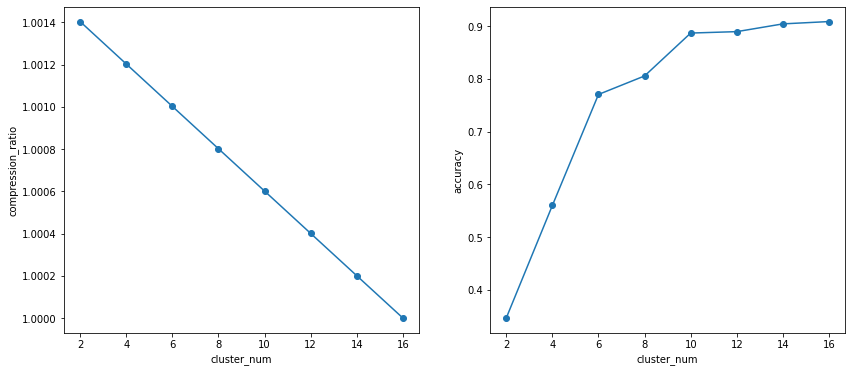

In [127]:
plot(cluster_nums, compression_ratios, accuracies)

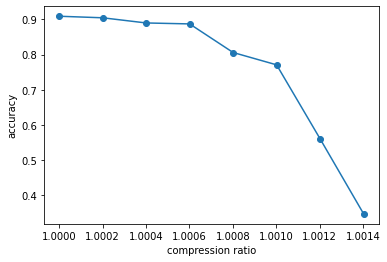

In [128]:
plt.plot(compression_ratios, accuracies, '-o', label='accuracy')
plt.xlabel('compression ratio')
plt.ylabel('accuracy');

## hand picked

In [111]:
pruned_model, n_unique_conv_params = prune(model, KMeans_cosine_distance(), 
                                            [16, 16, 26, 52])
pruned_model.to(device)
compression_ratio = total_params / (n_unique_conv_params + total_params - total_conv_params)
accuracy = calculate_accuracy(pruned_model, test_loader, device)
print(f'\n\ncompression_ratio: {compression_ratio}, accuracy: {accuracy}')

100%|██████████| 20/20 [00:02<00:00,  9.06it/s]



compression_ratio: 1.21385946121097, accuracy: 0.4974


In [115]:
pruned_model, n_unique_conv_params = prune(model, KMeans_cosine_distance(), 
                                            [16, 16, 26, 25])
pruned_model.to(device)
compression_ratio = total_params / (n_unique_conv_params + total_params - total_conv_params)
accuracy = calculate_accuracy(pruned_model, test_loader, device)
print(f'\n\ncompression_ratio: {compression_ratio}, accuracy: {accuracy}')

100%|██████████| 20/20 [00:02<00:00,  9.07it/s]



compression_ratio: 1.9735852370011562, accuracy: 0.1829


# Выводы

На последнем слое свертки наиболее глубокие, их кластеризация дает наибольшее сжатие.

На самом первом слое conv1 свертки кластеризовались относительно хорошо: при выделении до четверти от максимального числа кластеров, точность упала не сильно по сравнению с другими слоями. (Нужно еще проверить размеры кластеров, могли образоваться 3 кластера по 1 свертке). Но экономия числа параметров мизерная.

Лучшие результаты показала кластеризация сверток на последнем третьем слое: при степени сжатия примерно 1.25 точность упала до 0.8.

Метод показал себя не рабочим: падение качества значительно, но можно попробовать улучшить. Результат зависит от качества кластеризации, можно попробовать другие алгоритмы кластеризации и расстояния между свертками. Также для каждого сверточного слоя подбирать автоматически по метрикам кластеризации свое оптимальное чисо кластеров. И, как предлагалось, дообучить сеть вместе с прунингом.